# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you find **at least two datasets** on the web which are related, and that you visualize these datasets to answer the assignment question. You are free to utilize datasets with any location or domain, the usage of **Ann Arbor sports and athletics** datasets in the example is just a suggestion.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * You must state a question you are seeking to answer with your visualizations.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together as an example! [Example Solution File](./readonly/Assignment4_example.pdf)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#https://www.kaggle.com/datasets/robikscube/zillow-home-value-index
home_value = pd.read_csv('ZHVI.csv',index_col=0)
#https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html
income = pd.read_excel('h08.xlsx',header=[7,8],nrows=52)
#income had a multiindex header so flattening it down
income.columns =  income.columns.to_flat_index()
income.columns = income.columns.map(lambda x: "_".join(map(str,x)))
income.rename(columns={'State_Unnamed: 0_level_1':'State'},inplace=True)

In [3]:
#Narrowing Data to Michigan only and transposing for a time series analysis
MI_homes = home_value['Michigan'].T.reset_index()
MI_income = income[income['State']=='Michigan'].T.reset_index()

In [4]:
#Getting the Year as its own column
years = income.columns.map(lambda x: x.split('_'))
new_year = years.map(lambda x: x[0])
MI_income['year'] = new_year

In [5]:
#In 2017 they redid the data processing so keeping the newer one. They also redid the survey question in 2013, getting rid of the other footnotes
MI_income = (MI_income[~(MI_income['year'].isin(['2017','2013 (39)']))]).replace('(\([\d\w]*\))','',regex=True)

In [6]:
#Getting the data to the form where the year is the index and Median and the Standard Error are columns
medians = MI_income[MI_income['index'].str.contains('Median')]
se = MI_income[MI_income['index'].str.contains('error')]
Income = pd.merge(medians,se,how='outer',on='year')
Income = Income[['23_x','year','23_y']]
Income['year'] = pd.to_datetime(Income['year'])
Income = Income.rename(columns={'23_x':'Median','23_y':'SE'}).set_index('year')
Income.sort_index(inplace=True)

In [7]:
MI_homes['index'] = pd.to_datetime(MI_homes['index'])
MI_homes = MI_homes.rename(columns={'index':'date'}).set_index('date')

In [8]:
#Finding the factor of median income to the home values
comparison = pd.merge(MI_homes,Income,left_index=True,right_index=True)
comparison['Factor of Income'] = comparison['Michigan'] / comparison['Median']

In [9]:
#Getting the points where housing prices dipped for a bit
early_spike_val = max(MI_homes[MI_homes.index < '2012-01-01']['Michigan'])
early_spike_date = pd.to_datetime(MI_homes[MI_homes['Michigan'] == early_spike_val].index.values[0])
early_dip_val = min(MI_homes[MI_homes.index > '2008-01-01']['Michigan'])
early_dip_date = pd.to_datetime(MI_homes[MI_homes['Michigan'] == early_dip_val].index.values[0])

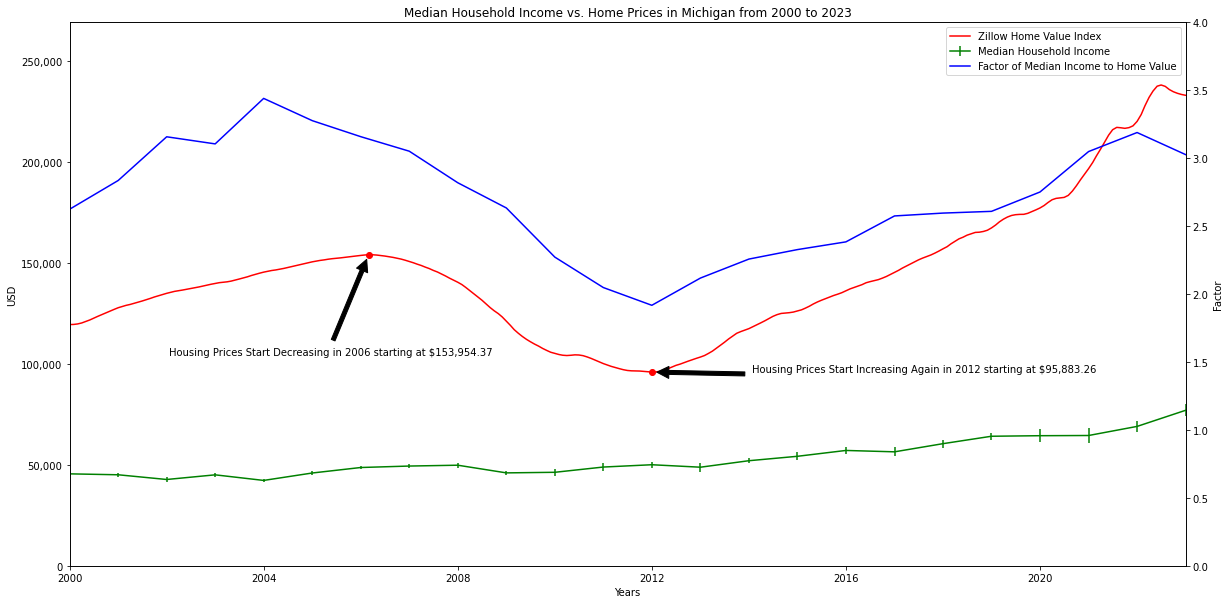

In [36]:
fig, ax1 = plt.subplots(figsize=(20,10))
ln1 = ax1.errorbar(Income.index,Income['Median'],yerr=Income['SE'],label='Median Household Income',color='Green')
ln2 = ax1.plot(MI_homes.index,MI_homes['Michigan'],label='Zillow Home Value Index',color='Red')
#Income Data only contained 2000-2023 data so limiting x axis to those years
ax1.set_xlim([pd.to_datetime('2000-01-01'),pd.to_datetime('2023-01-01')])
ax1.xaxis.set_major_locator
ax1.set_ylim([0,None])
#adding some points that point out when house prices fell and then rose
ax1.plot(early_spike_date,early_spike_val,'ro')
ax1.plot(early_dip_date,early_dip_val,'ro')
ax1.annotate('Housing Prices Start Decreasing in {} starting at ${:,}'.format(early_spike_date.year,round(early_spike_val,2)),xy=(early_spike_date,early_spike_val),xytext=(-200,-100),
                arrowprops=dict(facecolor='black', shrink=0.05),textcoords='offset points')
ax1.annotate('Housing Prices Start Increasing Again in {} starting at ${:,}'.format(early_dip_date.year,round(early_dip_val,2)),xy=(early_dip_date,early_dip_val),xytext=(100,0),
                arrowprops=dict(facecolor='black', shrink=0.05),textcoords='offset points')
ax1.set_title('Median Household Income vs. Home Prices in Michigan from 2000 to 2023')
ax1.set_xlabel('Years')
ax1.yaxis.set_major_formatter((lambda x, p: format(int(x), ',')))
ax1.set_ylabel('USD')
ax2 = ax1.twinx()
ln3 = ax2.plot(comparison.index,comparison['Factor of Income'],label='Factor of Median Income to Home Value',color='Blue')
ax2.set_ylabel('Factor')
ax2.set_ylim([0,4])
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()
fig.savefig('housing_analysis.png', transparent=False,bbox_inches='tight',facecolor=('white'))